In [79]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

F, L = len("Bartosz"), len("Zak")

## Excercise 1 -  Generated Quantities Block

Write to file

In [80]:
%%writefile code_1.stan

data {
  int M;//number of years analyzed
}

generated quantities {
  real lambda=fabs(normal_rng(0,121));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}

Overwriting code_1.stan


In [81]:
gen_quant = CmdStanModel(stan_file='code_1.stan')

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab2/code_1.stan to exe file /root/Data_Analytics/lab2/code_1
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab2/code_1
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab2/code_1.hpp /root/Data_Analytics/lab2/code_1.stan
Warning in '/root/Data_Analytics/lab2/code_1.stan', line 8, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math

In [82]:
samples = gen_quant.sample(data={'M':F}, 
                            fixed_param=True, 
                            iter_sampling=1000, 
                            iter_warmup=0, 
                            chains = 1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [83]:
samples.column_names

('lp__',
 'accept_stat__',
 'lambda',
 'y_sim[1]',
 'y_sim[2]',
 'y_sim[3]',
 'y_sim[4]',
 'y_sim[5]',
 'y_sim[6]',
 'y_sim[7]')

In [84]:
draws = samples.draws()[:, :, 2:]
df = pd.DataFrame(draws.reshape((1000, 8)))
df

,0,1,2,3,4,5,6,7
0,193.70000,194.0,201.0,190.0,198.0,198.0,227.0,207.0
1,54.59300,51.0,57.0,66.0,59.0,52.0,64.0,54.0
2,68.86870,71.0,57.0,76.0,62.0,63.0,67.0,70.0
3,162.68600,159.0,154.0,155.0,172.0,164.0,160.0,166.0
4,206.27800,197.0,193.0,218.0,232.0,199.0,210.0,209.0
...,...,...,...,...,...,...,...,...
995,9.23750,12.0,9.0,9.0,8.0,6.0,9.0,8.0
996,327.08200,327.0,313.0,327.0,331.0,356.0,333.0,329.0
997,77.19610,74.0,76.0,60.0,73.0,73.0,78.0,72.0
998,74.29730,74.0,65.0,85.0,61.0,70.0,72.0,86.0


In [85]:
df.columns = samples.column_names[2:]
df

,lambda,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],y_sim[6],y_sim[7]
0,193.70000,194.0,201.0,190.0,198.0,198.0,227.0,207.0
1,54.59300,51.0,57.0,66.0,59.0,52.0,64.0,54.0
2,68.86870,71.0,57.0,76.0,62.0,63.0,67.0,70.0
3,162.68600,159.0,154.0,155.0,172.0,164.0,160.0,166.0
4,206.27800,197.0,193.0,218.0,232.0,199.0,210.0,209.0
...,...,...,...,...,...,...,...,...
995,9.23750,12.0,9.0,9.0,8.0,6.0,9.0,8.0
996,327.08200,327.0,313.0,327.0,331.0,356.0,333.0,329.0
997,77.19610,74.0,76.0,60.0,73.0,73.0,78.0,72.0
998,74.29730,74.0,65.0,85.0,61.0,70.0,72.0,86.0


Histograms:

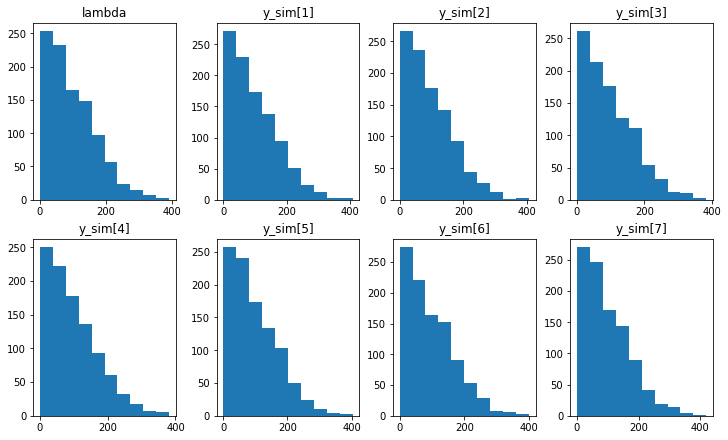

In [86]:
rows = 2
_, axs = plt.subplots(rows, len(df.columns) // rows, figsize = (10, 6), constrained_layout=True)
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.hist(df.iloc[:, i])
    ax.set_title(df.columns[i])

plt.show()

## Excercise 2 - Constraints on the data 

In [87]:
%%writefile code_2.stan

data {
  int N;
  int y[N];
}

parameters {
  real<lower=0,upper=1> theta;
}

model {
  theta ~ beta(1,1);
  y ~ bernoulli(theta);
}

Overwriting code_2.stan


In [88]:
%%writefile code_3.stan

data {
    int<lower=1> N;
    int<lower=0,upper=1> y[N];
}

parameters {
  real<lower=0,upper=1> theta;
}

model {
    theta ~ beta(1, 1);
    y ~ bernoulli(theta);
}

Overwriting code_3.stan


In [89]:
bern1 = CmdStanModel(stan_file='code_2.stan')
samp_bern1 = bern1.sample(data={'N':2, 'y':[0,2]})

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab2/code_2.stan to exe file /root/Data_Analytics/lab2/code_2
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab2/code_2
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab2/code_2.hpp /root/Data_Analytics/lab2/code_2.stan
Warning in '/root/Data_Analytics/lab2/code_2.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math


INFO:cmdstanpy:CmdStan done processing.


RuntimeError: Error during sampling:
Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)
	Exception: bernoulli_lpmf: n[2] is 2, but must be in the interval [0, 1] (in '/root/Data_Analytics/lab2/code_2.stan', line 13, column 2 to column 23)Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/root/Data_Analytics/lab2/code_2', 'id=1', 'random', 'seed=73910', 'data', 'file=/tmp/tmpbr8aj51b/qmfywwdr.json', 'output', 'file=/tmp/tmpbr8aj51b/code_2-20230323001106_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpbr8aj51b/code_2-20230323001106_1.csv
 console_msgs (if any):
	/tmp/tmpbr8aj51b/code_2-20230323001106_0-stdout.txt

In [90]:
bern2 = CmdStanModel(stan_file='code_3.stan')
samp_bern2 = bern2.sample(data={'N':2, 'y':[0,2]})

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab2/code_3.stan to exe file /root/Data_Analytics/lab2/code_3
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab2/code_3
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab2/code_3.hpp /root/Data_Analytics/lab2/code_3.stan
Warning in '/root/Data_Analytics/lab2/code_3.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math


INFO:cmdstanpy:CmdStan done processing.


RuntimeError: Error during sampling:
Exception: code_3_model_namespace::code_3_model: y[2] is 2, but must be less than or equal to 1.000000 (in '/root/Data_Analytics/lab2/code_3.stan', line 4, column 4 to column 30)
Exception: code_3_model_namespace::code_3_model: y[2] is 2, but must be less than or equal to 1.000000 (in '/root/Data_Analytics/lab2/code_3.stan', line 4, column 4 to column 30)
Exception: code_3_model_namespace::code_3_model: y[2] is 2, but must be less than or equal to 1.000000 (in '/root/Data_Analytics/lab2/code_3.stan', line 4, column 4 to column 30)
Exception: code_3_model_namespace::code_3_model: y[2] is 2, but must be less than or equal to 1.000000 (in '/root/Data_Analytics/lab2/code_3.stan', line 4, column 4 to column 30)Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/root/Data_Analytics/lab2/code_3', 'id=1', 'random', 'seed=16288', 'data', 'file=/tmp/tmpbr8aj51b/wmy9xid2.json', 'output', 'file=/tmp/tmpbr8aj51b/code_3-20230323001430_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpbr8aj51b/code_3-20230323001430_1.csv
 console_msgs (if any):
	/tmp/tmpbr8aj51b/code_3-20230323001430_0-stdout.txt

The model crashes, because value $2$ of $y$ is not valid for Bernoulli distribution.

## Excercise 3 - Constraints on parameters

### Unconstrained parameters

In [91]:
%%writefile code_4.stan

parameters {
  real theta;
}
model {
  theta ~ gamma(1.25, 1.25);
}

Overwriting code_4.stan


In [92]:
model_gm1 = CmdStanModel(stan_file='code_4.stan')
out_gamma1 = model_gm1.sample(output_dir='samples',iter_sampling=6000,iter_warmup=1000, seed=4838282)
print(out_gamma1.diagnose())


INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab2/code_4.stan to exe file /root/Data_Analytics/lab2/code_4
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab2/code_4
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /root/Data_Analytics/lab2/samples/code_4-20230323001458_1.csv, /root/Data_Analytics/lab2/samples/code_4-20230323001458_2.csv, /root/Data_Analytics/lab2/samples/code_4-20230323001458_3.csv, /root/Data_Analytics/lab2/samples/code_4-20230323001458_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
9489 of 24000 (39.54%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [93]:
out_gamma1.column_names

('lp__',
 'accept_stat__',
 'stepsize__',
 'treedepth__',
 'n_leapfrog__',
 'divergent__',
 'energy__',
 'theta')

In [94]:
out_gamma1.draws().shape

(6000, 4, 8)

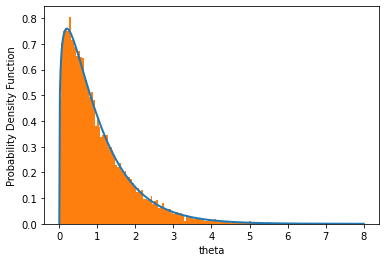

In [95]:
N=500
xs = np.linspace(0,8,N)
pdfs = stats.gamma.pdf(xs, 1.25, scale = 1 / 1.25) 

plt.plot(xs, pdfs, linewidth=2)

plt.hist(out_gamma1.draws().reshape(6000 * 4, 8)[:, -1], density=True, bins=160)

plt.gca().set_xlabel("theta")
plt.gca().set_ylabel("Probability Density Function")
plt.show()


### Constrained parameter

In [96]:
%%writefile code_5.stan

parameters {
  real<lower=0> theta;
}
model {
  theta ~ gamma(1.25, 1.25);
}

Overwriting code_5.stan


In [97]:
model_gm2 = CmdStanModel(stan_file='code_5.stan')
out_gamma2 = model_gm2.sample(output_dir='samples',iter_sampling=6000,iter_warmup=1000, seed=4838282)
print(out_gamma2.diagnose())

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab2/code_5.stan to exe file /root/Data_Analytics/lab2/code_5
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab2/code_5
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▉   | 00:00 Iteration: 4700 / 7000 [ 67%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /root/Data_Analytics/lab2/samples/code_5-20230323001504_1.csv, /root/Data_Analytics/lab2/samples/code_5-20230323001504_2.csv, /root/Data_Analytics/lab2/samples/code_5-20230323001504_3.csv, /root/Data_Analytics/lab2/samples/code_5-20230323001504_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
2 of 24000 (0.01%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



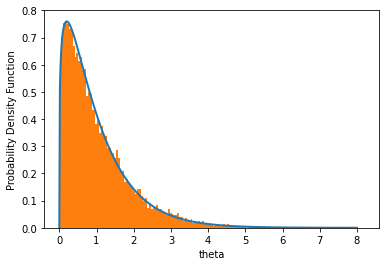

In [98]:
N=500
xs = np.linspace(0,8,N)
pdfs = stats.gamma.pdf(xs, 1.25, scale = 1 / 1.25) 

plt.plot(xs, pdfs, linewidth=2)

plt.hist(out_gamma2.draws().reshape(6000 * 4, 8)[:, -1], density=True, bins=160)

plt.gca().set_xlabel("theta")
plt.gca().set_ylabel("Probability Density Function")
plt.show()

According to the diagnostic logs, applying constraints resulted in the removal of most of the divergences.

## Excercise 4 -  Selection of parameters using equation solving



In [99]:
%%writefile code_6.stan

functions {
    vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
        vector[1] deltas;
        deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
        return deltas;
    }
}
data {
    vector[1] y_guess;
    vector[1] theta;
}

transformed data {
    vector[1] y;
    real x_r[0];
    int x_i[0];
    
    y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
    
    print("Standard deviation = ", exp(y[1]));
}

generated quantities {
    real sigma = exp(y[1]);
}

Overwriting code_6.stan


In [100]:
model_tune = CmdStanModel(stan_file='code_6.stan')

y0 = 0

data={'y_guess':[y0],
        'theta':[(F+L)/2]}
tunes = model_tune.sample(data=data, fixed_param=True, iter_sampling=1, iter_warmup=0, chains = 1)

print(f"Standard deviation of half_normal distribution such that with 99% probability samples from it will be less than {(F+L)/2} is {tunes.draws()[0, 0, 2]}")

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab2/code_6.stan to exe file /root/Data_Analytics/lab2/code_6
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab2/code_6
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab2/code_6.hpp /root/Data_Analytics/lab2/code_6.stan
Warning in '/root/Data_Analytics/lab2/code_6.stan', line 3, column 46: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/root/Data_Analytics/lab2/code_6.stan', line 3, column 58: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/root/Data_Analytics/lab2/code_6.stan', line 16, col


INFO:cmdstanpy:CmdStan done processing.



Standard deviation of half_normal distribution such that with 99% probability samples from it will be less than 5.0 is 1.94112


## Excercise 5 - different methods of defining models


In [101]:
%%writefile code_7.stan

data {
    int<lower=1> N;
}

parameters {
    real y[N];
    real theta;
}

model {
    y ~ normal(theta, 1);
    theta ~ normal(0, 1);
}

Overwriting code_7.stan


In [102]:
%%writefile code_8.stan

data {
    int<lower=1> N;
}

parameters {
    real y[N];
    real theta;
}

model {
    target += normal_lpdf(y | theta, 1);
    target += normal_lpdf(theta | 0, 1);
}

Overwriting code_8.stan


In [103]:
%%writefile code_9.stan

data {
    int<lower=1> N;
}

parameters {
    real y[N];
    real theta;
}

model {
    for (n in 1:N) 
        target += normal_lpdf(y[n] | theta, 1);   
    
    target += normal_lpdf(theta | 0, 1);
}

Overwriting code_9.stan


In [104]:
model_samp_st = CmdStanModel(stan_file='code_7.stan')
model_log_target = CmdStanModel(stan_file='code_8.stan')
model_log_target_ind = CmdStanModel(stan_file='code_9.stan')
data = {'N': F}
seed = 4072000
result_1 = model_samp_st.sample(data=data,seed=seed)
result_2 = model_log_target.sample(data=data,seed=seed)
result_3 = model_log_target_ind.sample(data=data,seed=seed)

INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab2/code_7.stan to exe file /root/Data_Analytics/lab2/code_7
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab2/code_7
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab2/code_7.hpp /root/Data_Analytics/lab2/code_7.stan
Warning in '/root/Data_Analytics/lab2/code_7.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


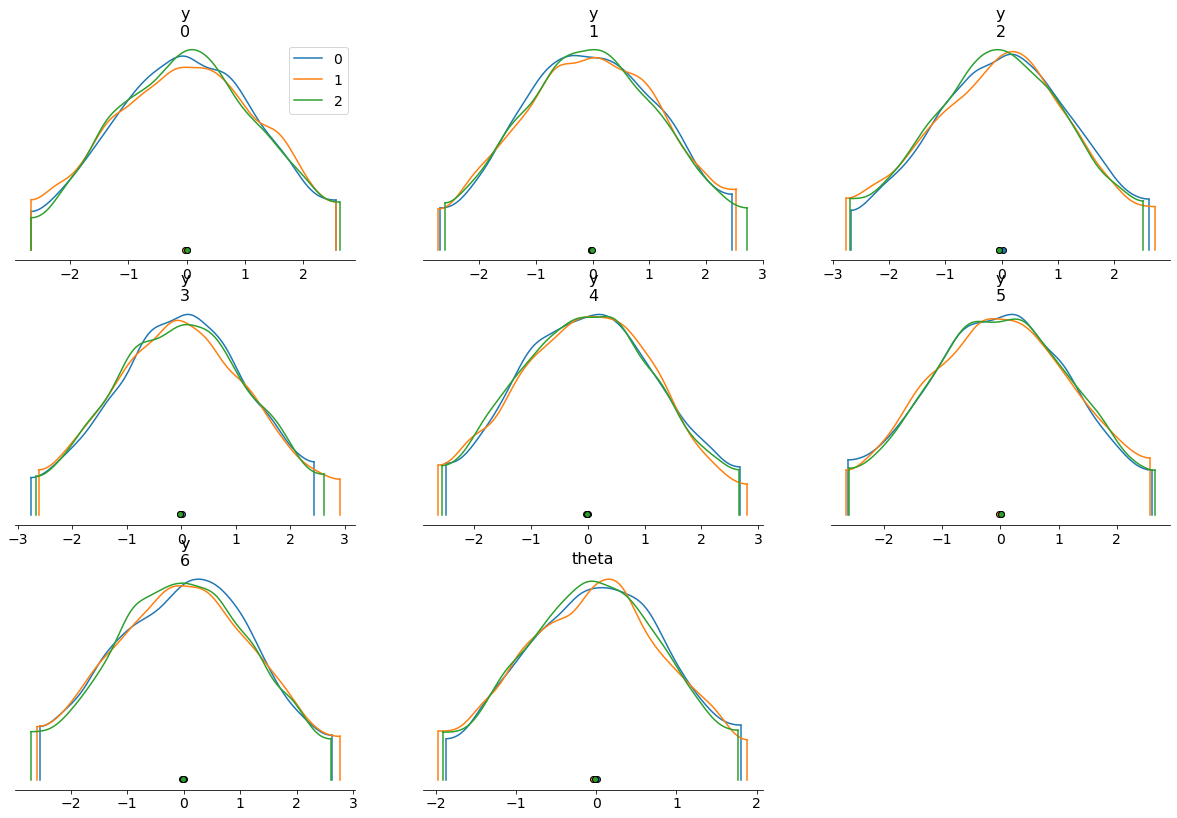

In [105]:
az.plot_density([result_1,result_2,result_3])
plt.show()

## Excercise 6 - generated quantities post sampling

In [106]:
%%writefile code_10.stan

data {
    int<lower=1> N;
}

parameters {
    real y[N];
    real theta;
}

model {
    y ~ normal(theta, 1);
    theta ~ normal(0, 1);
}

generated quantities {
    real mean_y = mean(y);
}

Overwriting code_10.stan


INFO:cmdstanpy:compiling stan file /root/Data_Analytics/lab2/code_10.stan to exe file /root/Data_Analytics/lab2/code_10
INFO:cmdstanpy:compiled model executable: /root/Data_Analytics/lab2/code_10
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/Data_Analytics/lab2/code_10.hpp /root/Data_Analytics/lab2/code_10.stan
Warning in '/root/Data_Analytics/lab2/code_10.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/sta

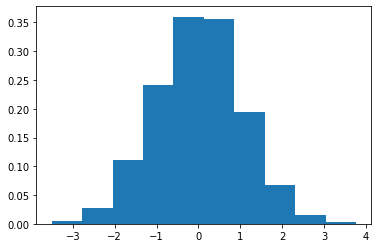

In [107]:
model_gq = CmdStanModel(stan_file='code_10.stan')
# fill in with chosen result from previous excercise
mean_of_y = model_gq.generate_quantities(data=data,
                                        mcmc_sample = result_1)
# investigate the output and plot histogram of mean_y variable
plt.hist(mean_of_y.draws_pd()['mean_y'], density=True)
plt.show()